#### ter12577- UWGeodynamics v2.12.4

# Timing of partial melting and granulitisation during the formation of high to ultra-high temperature terranes: insight from numerical experiments: Cenki, Rey and Arcay

The following notebook reproduces the numerical models presented in Cenki et al, 2021. This notebook has been strongly modified from "Script-G47301_285-Cenki-Tok-etal" by B. Cenki-Tok et al., 2020. More info on the code used under https://github.com/underworldcode/UWGeodynamics and https://www.underworldcode.org.

Cenki, B., Rey, P. F., Arcay, D. and Giordani, J. (2022). Timing of partial melting and granulite formation during the genesis of high to ultra-high temperature terranes: insight from numerical experiments. Terra Nova DOI: 10.1111/ter.12577


IMPORTANT NOTE:
Each model runs through the three following steps (to be restarted manually): 
i) a shortening phase during which the crust thickens to ~ 60 km with either a slow total velocity of 0.24 cm.y-1 during 70 my or a fast total velocity of 2.4 cm.y-1 during ~ 7 my (delivering a strain rate averaged over the length of the model of 1.6 x 10-16 s-1 and 1.6 x 10-15 s-1 respectively); 
ii) a rapid increase in BHF (from 0.020 W.m-2 to 0.030 W.m-2) over 2.5 my while the velocities imposed on the vertical boundaries are set to zero (vx = vy = 0 cm.y-1), mimicking the thermal impact of a delamination phase; 
iii) a relaxation phase in which the crust returns to normal thickness, under slow extensional boundary conditions (total velocity of 0.10 cm.y-1) associated to a slow decrease in BHF from 0.030 W.m-2 to 0.020 W.m- 2 in ~ 70 my.

In [1]:
import matplotlib.pyplot as plt
import UWGeodynamics as GEO
import underworld as uw
import underworld.function as fn
from UWGeodynamics.surfaceProcesses import SedimentationThreshold
import numpy as np
import scipy
import os.path
from mpi4py import MPI
import argparse
#import glucifer
from UWGeodynamics import visualisation as vis
import math

loaded rc file /home/julian/codes/uw_soft/UWGeo_worktree/development/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
GEO.__version__

'2.13.0-dev-20ce35c(development)'

# Working with units

Note that this is not an obligation and you can use values without units 


The geodynamics module enables usage of a broad range of units using a *UnitRegistry*. You can attach a unit to any value that you need to define. A value with a units attached becomes a *Quantity* python object. The geodynamics module take care of the conversion internally so you may use any units that you think are appropriate. You can also mix them.

The module will also try to work out a scaling of the values to help the computation process. The user can chose to alter the way his or her values are scaled or can rely on the default options.

To use the units system, you can link the unit registry as follow:

In [3]:
u = GEO.UnitRegistry

## Scaling

In [4]:
resolution = (240,80)
half_rate = 18 * u.millimeter / u.year
model_length = 480e3 * u.meter
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK
bodyforce = 3370 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

# Model setup

The starting model is 480 km long and 160 km thick, and includes 20 km of air-like material (low density, low viscosity) and a 35 to 40 km thick crust above 105 to 100 km of upper mantle.

In [5]:
Model = GEO.Model(elementRes=resolution, 
                  minCoord=(0. * u.kilometer, -140. * u.kilometer), 
                  maxCoord=(480. * u.kilometer, 20. * u.kilometer), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

	Global element size: 240x80
	Local offset of rank 0: 0x0
	Local range of rank 0: 240x80
In func WeightsCalculator_CalculateAll(): for swarm "P4GMCM88__swarm"
	done 33% (6400 cells)...
	done 67% (12800 cells)...
	done 100% (19200 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "P4GMCM88__swarm"


In [6]:
Model.outputDir="out1"

For all rocks, we assume a heat capacity of 1000 J kg−1 K−1 and thermal diffusivity of 1·10−6 m2 s−1.

In [7]:
Model.diffusivity = 1e-6 * u.metre**2 / u.second 
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)

### Air Layer

In [8]:
air = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=0 * u.kilometer))
air.density = 1. * u.kilogram / u.metre**3
air.diffusivity = 1e-6 * u.metre**2 / u.second
air.capacity = 1000. * u.joule / (u.kelvin * u.kilogram)

### Sediment

In [9]:
sediment = Model.add_material(name="Sediment")
sediment.density           = GEO.LinearDensity(reference_density=2300. * u.kilogram / u.metre**3)
sediment.radiogenicHeatProd   = 0.7 * u.microwatt / u.meter**3

### Continental Crust (Activate for Model 1)

Because the composition of the continental crust changes with depth,
an increase in density is expected toward the Moho. The continental crust can become granulitic under specific Temperature and strain rate conditions (see below). The reference density for the continental crust is 2600 kg.m−3 and the granulitic continental crust is 2950 kg.m−3. The conditions for model 1 include a total RHP of 2.0922 microW.m-3 with high RHP in the upper crust (5e-6 W.m-3) that decreases exponentially with a length scale factor hc of 20 km, yielding an initial Moho temperature at 35 km depth of 650°C.

In [10]:
#continentalcrustL1 = Model.add_material(name="Continental Crust Layer1", shape=GEO.shapes.Layer(top=0. * u.kilometer, bottom=-5.5 * u.kilometer))
#continentalcrustL1.radiogenicHeatProd = 5.20000000e-06  * u.watt / u.meter**3
#continentalcrustL1.density  = GEO.LinearDensity(reference_density  = 2600. * u.kilogram / u.metre**3)

In [11]:
#continentalcrustL2 = Model.add_material(name="Continental Crust Layer2", shape=GEO.shapes.Layer(top=-5.5 * u.kilometer, bottom=-11. * u.kilometer))
#continentalcrustL2.radiogenicHeatProd = 3.62791690e-06  * u.watt / u.meter**3
#continentalcrustL2.density  = GEO.LinearDensity(reference_density  = 2600. * u.kilogram / u.metre**3)

In [12]:
#continentalcrustL3 = Model.add_material(name="Continental Crust Layer3", shape=GEO.shapes.Layer(top=-11. * u.kilometer, bottom=-16.5 * u.kilometer))
#continentalcrustL3.radiogenicHeatProd = 2.53111173e-06  * u.watt / u.meter**3
#continentalcrustL3.density  = GEO.LinearDensity(reference_density  = 2600. * u.kilogram / u.metre**3)

In [13]:
#continentalcrustL4 = Model.add_material(name="Continental Crust Layer4", shape=GEO.shapes.Layer(top=-16.5 * u.kilometer, bottom=-22. * u.kilometer))
#continentalcrustL4.radiogenicHeatProd = 1.76589673e-06  * u.watt / u.meter**3
#continentalcrustL4.density  = GEO.LinearDensity(reference_density  = 2600. * u.kilogram / u.metre**3)

In [14]:
#continentalcrustL5 = Model.add_material(name="Continental Crust Layer5", shape=GEO.shapes.Layer(top=-22. * u.kilometer, bottom=-27.5 * u.kilometer))
#continentalcrustL5.radiogenicHeatProd = 1.23202435e-06  * u.watt / u.meter**3
#continentalcrustL5.density  = GEO.LinearDensity(reference_density  = 2600. * u.kilogram / u.metre**3)

In [15]:
#continentalcrustL6 = Model.add_material(name="Continental Crust Layer6", shape=GEO.shapes.Layer(top=-27.5 * u.kilometer, bottom=-33. * u.kilometer))
#continentalcrustL6.radiogenicHeatProd = 8.59554219e-07  * u.watt / u.meter**3
#continentalcrustL6.density  = GEO.LinearDensity(reference_density  = 2600. * u.kilogram / u.metre**3)

In [16]:
#retrogressedcontinentalcrust = Model.add_material(name="Retrogressed Continental Crust")
#retrogressedcontinentalcrust.radiogenicHeatProd = 1.0483e-06 * u.watt / u.meter**3
#retrogressedcontinentalcrust.density  = GEO.LinearDensity(reference_density  = 2600. * u.kilogram / u.metre**3)

In [17]:
#granuliticcontinentalcrust = Model.add_material(name="Granulite Continental Crust")
#granuliticcontinentalcrust.radiogenicHeatProd = 1.0483e-06 * u.watt / u.meter**3
#granuliticcontinentalcrust.density  = GEO.LinearDensity(reference_density  = 2950. * u.kilogram / u.metre**3)

### Continental Crust (Activate for Model 2)

Because the composition of the continental crust changes with depth,
an increase in density is expected toward the Moho. The continental crust can become granulitic under specific Temperature and strain rate conditions (see below). The reference density for the continental crust is 2600 kg.m−3 and the granulitic continental crust is 2950 kg.m−3. The conditions for Model 2 have a uniform continental crust RHP (1.0483 microW.m-3), yielding an initial Moho temperature of 650°C at 40 km depth.

In [18]:
continentalcrustL1 = Model.add_material(name="Continental Crust Layer1", shape=GEO.shapes.Layer(top=0. * u.kilometer, bottom=-4 * u.kilometer))
continentalcrustL1.radiogenicHeatProd = 1.0483e-06  * u.watt / u.meter**3
continentalcrustL1.density  = GEO.LinearDensity(reference_density  = 2600. * u.kilogram / u.metre**3)

In [19]:
continentalcrustL2 = Model.add_material(name="Continental Crust Layer2", shape=GEO.shapes.Layer(top=-4 * u.kilometer, bottom=-12. * u.kilometer))
continentalcrustL2.radiogenicHeatProd = 1.0483e-06  * u.watt / u.meter**3
continentalcrustL2.density  = GEO.LinearDensity(reference_density  = 2600. * u.kilogram / u.metre**3)

In [20]:
continentalcrustL3 = Model.add_material(name="Continental Crust Layer3", shape=GEO.shapes.Layer(top=-12. * u.kilometer, bottom=-20 * u.kilometer))
continentalcrustL3.radiogenicHeatProd = 1.0483e-06  * u.watt / u.meter**3
continentalcrustL3.density  = GEO.LinearDensity(reference_density  = 2600. * u.kilogram / u.metre**3)

In [21]:
continentalcrustL4 = Model.add_material(name="Continental Crust Layer4", shape=GEO.shapes.Layer(top=-20 * u.kilometer, bottom=-28. * u.kilometer))
continentalcrustL4.radiogenicHeatProd = 1.0483e-06  * u.watt / u.meter**3
continentalcrustL4.density  = GEO.LinearDensity(reference_density  = 2600. * u.kilogram / u.metre**3)

In [22]:
continentalcrustL5 = Model.add_material(name="Continental Crust Layer5", shape=GEO.shapes.Layer(top=-28. * u.kilometer, bottom=-36 * u.kilometer))
continentalcrustL5.radiogenicHeatProd = 1.0483e-06  * u.watt / u.meter**3
continentalcrustL5.density  = GEO.LinearDensity(reference_density  = 2600. * u.kilogram / u.metre**3)

In [23]:
continentalcrustL6 = Model.add_material(name="Continental Crust Layer6", shape=GEO.shapes.Layer(top=-36 * u.kilometer, bottom=-40. * u.kilometer))
continentalcrustL6.radiogenicHeatProd = 1.0483e-06  * u.watt / u.meter**3
continentalcrustL6.density  = GEO.LinearDensity(reference_density  = 2600. * u.kilogram / u.metre**3)

In [24]:
retrogressedcontinentalcrust = Model.add_material(name="Retrogressed Continental Crust")
retrogressedcontinentalcrust.radiogenicHeatProd = 1.0483e-06 * u.watt / u.meter**3
retrogressedcontinentalcrust.density  = GEO.LinearDensity(reference_density  = 2600. * u.kilogram / u.metre**3)

In [25]:
granuliticcontinentalcrust = Model.add_material(name="Granulite Continental Crust")
granuliticcontinentalcrust.radiogenicHeatProd = 1.0483e-06 * u.watt / u.meter**3
granuliticcontinentalcrust.density  = GEO.LinearDensity(reference_density  = 2950. * u.kilogram / u.metre**3)

### Upper-Mantle

At room conditions, the density of the mantle is 3370kgm−3 and has a coefficient of thermal expansion of 2.8·10−5 K−1

In [26]:
## ACTIVATE FOR MODEL 1
#uppermantle = Model.add_material(name="Upper Mantle", shape=GEO.shapes.Layer(top=-33. * u.kilometer, bottom=Model.bottom))
#uppermantle.density = GEO.LinearDensity(reference_density=3370. * u.kilogram / u.metre**3,
#                                        thermalExpansivity= 2.8e-5 * u.kelvin**-1)

In [27]:
## ACTIVATE FOR MODEL 2
uppermantle = Model.add_material(name="Upper Mantle", shape=GEO.shapes.Layer(top=-40. * u.kilometer, bottom=Model.bottom))
uppermantle.density = GEO.LinearDensity(reference_density=3370. * u.kilogram / u.metre**3,
                                        thermalExpansivity= 2.8e-5 * u.kelvin**-1)

### Visualisation of initial conditions


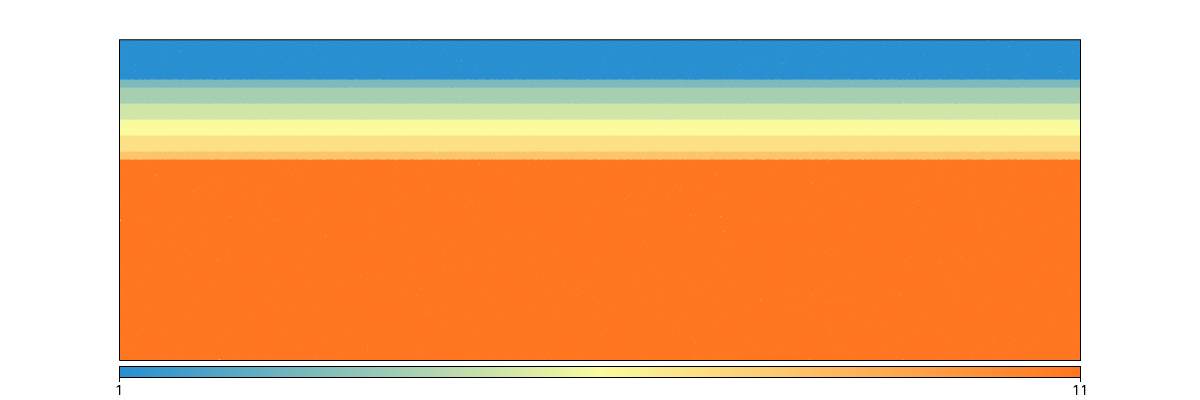

In [28]:
FigMat = vis.Figure(figsize=(1200,400))
FigMat.Points(Model.swarm, Model.materialField, fn_size=2.0)
FigMat.show()

# Define Viscosities

The crust and the mantle have a visco-plastic rheology with a
temperature and stress dependent viscosity for stresses below the yield stress,
and a depth dependent plastic branch above it.
We use power law relationships between strain rate and stress
to describe dislocation creep. 

The viscosity varies with the temperature and stress according to:

crust, A, n and Q are those of quartz-rich rock (pre-exponent Ac=6.6·10−8 MPa−nc
s−1, nc=3.1, Qc=135·10e3 Jmol−1, Paterson and Luan, 1990).  The rheology of granulitic continental crust is from Mackwell et al., 1998 (pre-exponent Ac=5.05·10−22 MPa−nc s−1, nc=4.7, Qc=4.85·10e5 Jmol−1). The rheology of the mantle has been simplified and is considered isoviscous (5·10e21 Pa.s)

In [29]:
rh = GEO.ViscousCreepRegistry()

Model.minViscosity = 1e18 * u.pascal * u.second
Model.maxViscosity = 1e23 * u.pascal * u.second

air.viscosity = 5e18 * u.pascal * u.second
continentalcrustL1.viscosity = rh.Wet_Quartz_Dislocation_Paterson_and_Luan_1990
continentalcrustL2.viscosity = rh.Wet_Quartz_Dislocation_Paterson_and_Luan_1990
continentalcrustL3.viscosity = rh.Wet_Quartz_Dislocation_Paterson_and_Luan_1990
continentalcrustL4.viscosity = rh.Wet_Quartz_Dislocation_Paterson_and_Luan_1990
continentalcrustL5.viscosity = rh.Wet_Quartz_Dislocation_Paterson_and_Luan_1990
continentalcrustL6.viscosity = rh.Wet_Quartz_Dislocation_Paterson_and_Luan_1990
retrogressedcontinentalcrust.viscosity = rh.Wet_Quartz_Dislocation_Paterson_and_Luan_1990
granuliticcontinentalcrust.viscosity = rh.Dry_Maryland_Diabase_Dislocation_Mackwell_et_al_1998
uppermantle.viscosity = 5e21 * u.pascal * u.second
sediment.viscosity         = rh.Wet_Quartz_Dislocation_Gleason_and_Tullis_1995

In the crust and the mantle, frictional sliding is modeled via a Mohr
Coulomb criterion with a cohesion (C0) of 15 MPa and a coefficient of friction (µ) of 0.44. In all material, the yield stress linearly drops to a maximum of 20% of its initial value when the accumulated strain reaches 0.5 (cf.Wijns et al., 2005 for details). For differential stresses reaching the yield stress, the material fails and deformation is modeled by an effective viscosity: ηyield=τyield/(2 · E) in which E is the second invariant of the strain rate tensor. 

In [30]:
continentalcrustL1.plasticity = GEO.DruckerPrager(name="Continental Crust",
                                                cohesion=15. * u.megapascal,
                                                cohesionAfterSoftening=3. * u.megapascal,
                                                frictionCoefficient=0.44,
                                                frictionAfterSoftening=0.088,
                                                epsilon1=0.0, epsilon2=0.5)
continentalcrustL1.stressLimiter = 150 * u.megapascal

continentalcrustL2.plasticity = GEO.DruckerPrager(name="Continental Crust",
                                                cohesion=15. * u.megapascal,
                                                cohesionAfterSoftening=3. * u.megapascal,
                                                frictionCoefficient=0.44,
                                                frictionAfterSoftening=0.088,
                                                epsilon1=0.0, epsilon2=0.5)
continentalcrustL2.stressLimiter = 150 * u.megapascal

continentalcrustL3.plasticity = GEO.DruckerPrager(name="Continental Crust",
                                                cohesion=15. * u.megapascal,
                                                cohesionAfterSoftening=3. * u.megapascal,
                                                frictionCoefficient=0.44,
                                                frictionAfterSoftening=0.088,
                                                epsilon1=0.0, epsilon2=0.5)
continentalcrustL3.stressLimiter = 150 * u.megapascal

continentalcrustL4.plasticity = GEO.DruckerPrager(name="Continental Crust",
                                                cohesion=15. * u.megapascal,
                                                cohesionAfterSoftening=3. * u.megapascal,
                                                frictionCoefficient=0.44,
                                                frictionAfterSoftening=0.088,
                                                epsilon1=0.0, epsilon2=0.5)
continentalcrustL4.stressLimiter = 150 * u.megapascal

continentalcrustL5.plasticity = GEO.DruckerPrager(name="Continental Crust",
                                                cohesion=15. * u.megapascal,
                                                cohesionAfterSoftening=3. * u.megapascal,
                                                frictionCoefficient=0.44,
                                                frictionAfterSoftening=0.088,
                                                epsilon1=0.0, epsilon2=0.5)
continentalcrustL5.stressLimiter = 150 * u.megapascal

continentalcrustL6.plasticity = GEO.DruckerPrager(name="Continental Crust",
                                                cohesion=15. * u.megapascal,
                                                cohesionAfterSoftening=3. * u.megapascal,
                                                frictionCoefficient=0.44,
                                                frictionAfterSoftening=0.088,
                                                epsilon1=0.0, epsilon2=0.5)
continentalcrustL6.stressLimiter = 150 * u.megapascal

retrogressedcontinentalcrust.plasticity = GEO.DruckerPrager(name="Continental Crust",
                                                cohesion=15. * u.megapascal,
                                                cohesionAfterSoftening=3. * u.megapascal,
                                                frictionCoefficient=0.44,
                                                frictionAfterSoftening=0.088,
                                                epsilon1=0.0, epsilon2=0.5)
retrogressedcontinentalcrust.stressLimiter = 150 * u.megapascal

granuliticcontinentalcrust.plasticity = GEO.DruckerPrager(name="Continental Crust",
                                                cohesion=15. * u.megapascal,
                                                cohesionAfterSoftening=3. * u.megapascal,
                                                frictionCoefficient=0.44,
                                                frictionAfterSoftening=0.088,
                                                epsilon1=0.0, epsilon2=0.5)
granuliticcontinentalcrust.stressLimiter = 150 * u.megapascal

uppermantle.plasticity = GEO.DruckerPrager(name="Continental Crust",
                                           cohesion=15. * u.megapascal,
                                           cohesionAfterSoftening=3. * u.megapascal,
                                           frictionCoefficient=0.44,
                                           frictionAfterSoftening=0.088,
                                           epsilon1=0.0, epsilon2=0.5)
uppermantle.stressLimiter = 100 * u.megapascal

sediment.plasticity = GEO.DruckerPrager(cohesion=20.0 * u.megapascal,
                               cohesionAfterSoftening=20 * u.megapascal,
                               frictionCoefficient=0.12,
                               frictionAfterSoftening=0.02,
                               epsilon1=0.5,
                               epsilon2=1.5)
sediment.stressLimiter = 100 * u.megapascal

## Melt

In [31]:
solidii = GEO.SolidusRegistry()
my_crust_solidus = GEO.Solidus(A1=923 * u.kelvin, A2=-1.2e-07 * u.kelvin / u.pascal, A3=1.2e-16 * u.kelvin / u.pascal**2, A4=0.0 * u.kelvin / u.pascal**3)
mid_crust_solidus = GEO.Solidus(A1=1263 * u.kelvin, A2=-1.2e-07 * u.kelvin / u.pascal, A3=1.2e-16 * u.kelvin / u.pascal**2, A4=0.0 * u.kelvin / u.pascal**3)

liquidii = GEO.LiquidusRegistry()
my_crust_liquidus = GEO.Liquidus(A1=1423 * u.kelvin, A2=-1.2e-07 * u.kelvin / u.pascal, A3=1.6e-16 * u.kelvin / u.pascal**2, A4=0.0 * u.kelvin / u.pascal**3)
mid_crust_liquidus = GEO.Liquidus(A1=1763 * u.kelvin, A2=-1.2e-07 * u.kelvin / u.pascal, A3=1.6e-16 * u.kelvin / u.pascal**2, A4=0.0 * u.kelvin / u.pascal**3)

In our experiments, the viscosity decreases linearly by 3 orders of magnitude when the melt fraction increases from 15 to 30%. When the melt fraction is 15%, the viscosity of the melted crust is that of the non-melted surrounding; when the melt fraction is 30%, its viscosity is a thousand times lower than in surrounding material. Rosenberg and Handy (2005) showed that significant weakening occurs at 7% melt fraction.

In [32]:
continentalcrustL1.add_melt_modifier(my_crust_solidus, my_crust_liquidus, 
                         latentHeatFusion=250.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.3,
                         meltExpansion=0.13, 
                         viscosityChangeX1 = 0.15,
                         viscosityChangeX2 = 0.30,
                         viscosityChange = 1e-3
                        )

continentalcrustL2.add_melt_modifier(my_crust_solidus, my_crust_liquidus, 
                         latentHeatFusion=250.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.3,
                         meltExpansion=0.13, 
                         viscosityChangeX1 = 0.15,
                         viscosityChangeX2 = 0.30,
                         viscosityChange = 1e-3
                        )

continentalcrustL3.add_melt_modifier(my_crust_solidus, my_crust_liquidus, 
                         latentHeatFusion=250.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.3,
                         meltExpansion=0.13, 
                         viscosityChangeX1 = 0.15,
                         viscosityChangeX2 = 0.30,
                         viscosityChange = 1e-3
                        )

continentalcrustL4.add_melt_modifier(my_crust_solidus, my_crust_liquidus, 
                         latentHeatFusion=250.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.3,
                         meltExpansion=0.13, 
                         viscosityChangeX1 = 0.15,
                         viscosityChangeX2 = 0.30,
                         viscosityChange = 1e-3
                        )

continentalcrustL5.add_melt_modifier(my_crust_solidus, my_crust_liquidus, 
                         latentHeatFusion=250.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.3,
                         meltExpansion=0.13, 
                         viscosityChangeX1 = 0.15,
                         viscosityChangeX2 = 0.30,
                         viscosityChange = 1e-3
                        )

continentalcrustL6.add_melt_modifier(my_crust_solidus, my_crust_liquidus, 
                         latentHeatFusion=250.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.3,
                         meltExpansion=0.13, 
                         viscosityChangeX1 = 0.15,
                         viscosityChangeX2 = 0.30,
                         viscosityChange = 1e-3
                        )

retrogressedcontinentalcrust.add_melt_modifier(my_crust_solidus, my_crust_liquidus, 
                         latentHeatFusion=250.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.3,
                         meltExpansion=0.13, 
                         viscosityChangeX1 = 0.15,
                         viscosityChangeX2 = 0.30,
                         viscosityChange = 1e-3
                        )

granuliticcontinentalcrust.add_melt_modifier(mid_crust_solidus, mid_crust_liquidus, 
                         latentHeatFusion=250.0 * u.kilojoules / u.kilogram / u.kelvin,
                         meltFraction=0.,
                         meltFractionLimit=0.3,
                         meltExpansion=0.13, 
                         viscosityChangeX1 = 0.15,
                         viscosityChangeX2 = 0.30,
                         viscosityChange = 1e-3
                        )  

## Temperature Boundary Condition
The geotherm is based on a constant heat flow imposed at the base of the model (0.020 W m−2), a constant temperature imposed at the top (20 °C).

In [33]:
Model.set_temperatureBCs(top=293.15 * u.degK, materials=[(air, 293.15*u.degK)])

In [34]:
Model.set_heatFlowBCs(bottom=(0.020 * u.watt / u.metre**2, uppermantle))

## Velocity Boundary Conditions (change according to model phase)

In [35]:
## ACTIVATE THIS CELL FOR PHASE 1 (SHORTENING) OF THE MODEL
## CHOOSE TO RUN EITHER WITH SLOW OR FAST VELOCITY: during the shortening phase the crust thickens to ~ 60 km with either a slow total velocity of 0.24 cm.y-1 during 70 my or a fast total velocity of 2.4 cm.y-1 during ~ 7 my
Model.set_velocityBCs(left=[2.4  * u.centimeter / u.year, 0 * u.centimeter / u.year],
                       right=[-2.4  * u.centimeter / u.year, 0 * u.centimeter / u.year],
                       bottom=GEO.LecodeIsostasy(reference_mat=uppermantle, average=False))

In [36]:
## ACTIVATE THIS CELL FOR PHASE 2 (DELAMINATION) OF THE MODEL
#Model.set_velocityBCs(left=[0  * u.centimeter / u.year, 0 * u.centimeter / u.year],
#                       right=[0  * u.centimeter / u.year, 0 * u.centimeter / u.year],
#                       bottom=GEO.LecodeIsostasy(reference_mat=uppermantle, average=False))

In [37]:
## ACTIVATE THIS CELL FOR PHASE 3 (COLLAPSE) OF THE MODEL
#Model.set_velocityBCs(left=[-0.10  * u.centimeter / u.year, 0 * u.centimeter / u.year],
#                       right=[0.10  * u.centimeter / u.year, 0 * u.centimeter / u.year],
#                       bottom=GEO.LecodeIsostasy(reference_mat=uppermantle, average=False))

# Random initial plastic strain damage zone

In [38]:
def gaussian(xx, centre, width):
    return ( np.exp( -(xx - centre)**2/width))

maxDamage = 0.2
centre = (GEO.nd(240. * u.kilometer), GEO.nd(-40. * u.kilometer))
width = GEO.nd(150. * u.kilometer) 

Model.plasticStrain.data[:] = maxDamage * np.random.rand(*Model.plasticStrain.data.shape[:])
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,0], centre[0], width)
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,1], centre[1], width*100)

air_mask = Model.swarm.particleCoordinates.data[:,1] > GEO.nd(0 * u.kilometer)

Model.plasticStrain.data[air_mask] = 0.0


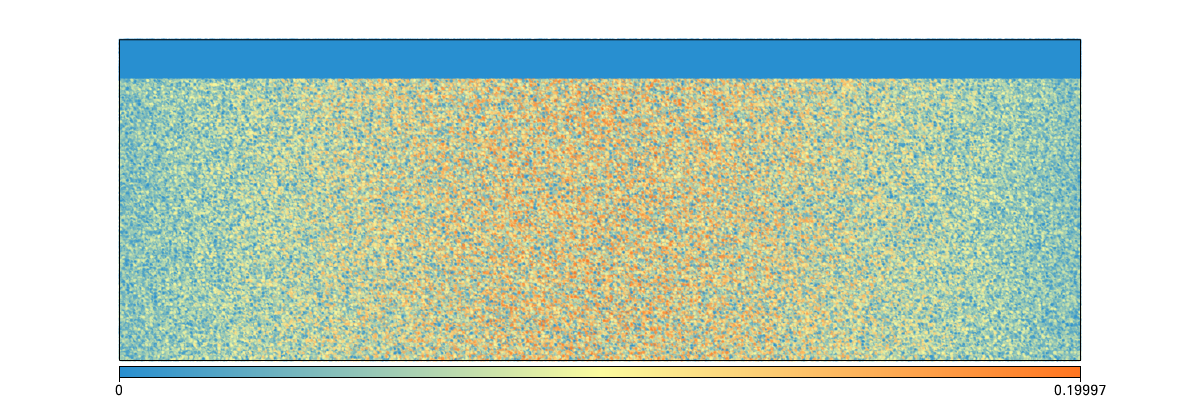

In [39]:
Fig = vis.Figure(figsize=(1200, 400))
Fig.Points(Model.swarm, Model.plasticStrain, fn_size=4.0)
Fig.show()

# Surface processes

In [40]:
Model.surfaceProcesses = GEO.surfaceProcesses.SedimentationThreshold(air=[air], sediment=[sediment], threshold=0. * u.metre)

In [41]:
Model.surfaceProcesses = GEO.surfaceProcesses.ErosionThreshold(air=[air], threshold=4000. * u.metre)

## Interface Tracers

In [42]:
npoints_surface = 1000
coords_surface = np.ndarray((npoints_surface, 2))
coords_surface[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints_surface)
coords_surface[:, 1] = GEO.nd(0. * u.kilometre)
Model.add_passive_tracers(name="Surface", vertices=coords_surface)

In [43]:
## ACTIVATE FOR MODEL 1
#npoints_moho = 1000
#coords_moho = np.ndarray((npoints_moho, 2))
#coords_moho[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints_moho)
#coords_moho[:, 1] = GEO.nd(0. * u.kilometre) - GEO.nd(33.* u.kilometre)
#moho_tracers = Model.add_passive_tracers(name="Moho", vertices=coords_moho)

In [44]:
## ACTIVATE FOR MODEL 2
npoints_moho = 1000
coords_moho = np.ndarray((npoints_moho, 2))
coords_moho[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints_moho)
coords_moho[:, 1] = GEO.nd(0. * u.kilometre) - GEO.nd(40.* u.kilometre)
Model.add_passive_tracers(name="Moho", vertices=coords_moho)

## Grid Tracers

In [45]:
coords_FSE_Crust = GEO.circles_grid(radius = 2.0 * u.kilometer,
                           minCoord=[Model.minCoord[0], continentalcrustL6.bottom],
                           maxCoord=[Model.maxCoord[0], 0.*u.kilometer])

Model.add_passive_tracers(name="FSE_Crust", vertices=coords_FSE_Crust)

# Lagrangian Grid

In [46]:
## ACTIVATE FOR MODEL 1
#cxpos = np.linspace(GEO.nd(10*u.kilometer), GEO.nd(710*u.kilometer),40)
#cypos = np.linspace(GEO.nd(-30*u.kilometer), GEO.nd(-5*u.kilometer),5)
#cxpos, cypos = np.meshgrid(cxpos, cypos)
#coords_centroid = np.ndarray((cxpos.size, 2))
#coords_centroid[:, 0] = cxpos.ravel()
#coords_centroid[:, 1] = cypos.ravel()
 
#coords = np.zeros((1, 2))
#Lag_Grid = Model.add_passive_tracers(name="Lag_grid", vertices=coords,
#                                      centroids=coords_centroid)

In [47]:
## ACTIVATE FOR MODEL 2
cxpos = np.linspace(GEO.nd(10*u.kilometer), GEO.nd(710*u.kilometer),40)
cypos = np.linspace(GEO.nd(-37*u.kilometer), GEO.nd(-5*u.kilometer),5)
cxpos, cypos = np.meshgrid(cxpos, cypos)
coords_centroid = np.ndarray((cxpos.size, 2))
coords_centroid[:, 0] = cxpos.ravel()
coords_centroid[:, 1] = cypos.ravel()
 
coords = np.zeros((1, 2))
Model.add_passive_tracers(name="Lag_Grid", vertices=coords,
                                      centroids=coords_centroid)


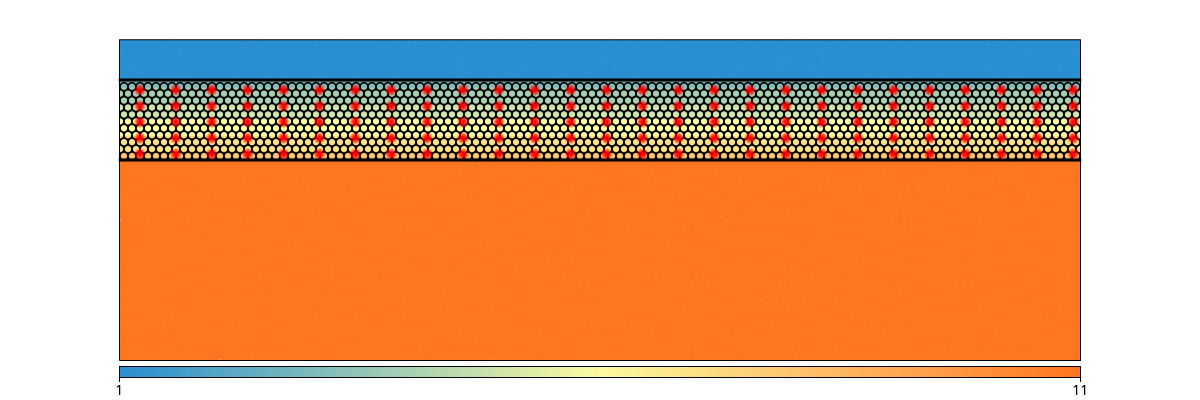

In [48]:
FigMat = vis.Figure(figsize=(1200,400))
FigMat.Points(Model.Lag_Grid_tracers, pointSize=12.0, colour="red")
FigMat.Points(Model.Surface_tracers, pointSize=4.0)
FigMat.Points(Model.Moho_tracers, pointSize=4.0)
FigMat.Points(Model.FSE_Crust_tracers, pointSize=2.0)
FigMat.Points(Model.swarm, Model.materialField, fn_size=2.0)
FigMat.show()

In [49]:
Model.Lag_Grid_tracers.add_tracked_field(Model.temperature, name="LagGridTemp", units=u.degK, dataType="float")
Model.Lag_Grid_tracers.add_tracked_field(Model.pressureField, name="LagGridPress", units=u.megapascal, dataType="float")
Model.Lag_Grid_tracers.add_tracked_field(Model.strainRate_2ndInvariant, name="LagGridStrainRate", units= u.second**-1, dataType="float")
Model.Lag_Grid_tracers.add_tracked_field(Model.viscosityField, name="LagGridViscosity", units=u.pascal * u.second, dataType="float")
Model.Lag_Grid_tracers.add_tracked_field(Model.timeField, name="LagGridTimeField", units=u.year, dataType="float")
Model.Lag_Grid_tracers.add_tracked_field(Model.materialField, name="LagGridMaterialField", units=None, dataType="float")
Model.Lag_Grid_tracers.add_tracked_field(Model.meltField, name="LagGridMeltField", units=None, dataType="float")

## Run Model

In [51]:
Model.init_model(temperature="steady-state")

In SystemLinearEquations_NonLinearExecute

Non linear solver - iteration 0
Linear solver (8QNOON0W__system-execute) 
Linear solver (8QNOON0W__system-execute), solution time 8.739773e-02 (secs)
Non linear solver - iteration 1
Linear solver (8QNOON0W__system-execute) 
Linear solver (8QNOON0W__system-execute), solution time 8.218799e-02 (secs)
In func SystemLinearEquations_NonLinearExecute: Iteration 1 of 500 - Residual 0.0068845 - Tolerance = 0.01
Non linear solver - Residual 6.88445565e-03; Tolerance 1.0000e-02 - Converged - 3.551393e-01 (secs)

In func SystemLinearEquations_NonLinearExecute: Converged after 1 iterations.


In [52]:
GEO.nd(500*u.kelvin)

0.3759398496240602

# Phase change algorithm

In [53]:
continentalcrustL1.phase_changes = GEO.PhaseChange((Model.temperature > GEO.nd(1050*u.kelvin)), granuliticcontinentalcrust.index)
continentalcrustL2.phase_changes = GEO.PhaseChange((Model.temperature > GEO.nd(1050*u.kelvin)), granuliticcontinentalcrust.index)
continentalcrustL3.phase_changes = GEO.PhaseChange((Model.temperature > GEO.nd(1050*u.kelvin)), granuliticcontinentalcrust.index)
continentalcrustL4.phase_changes = GEO.PhaseChange((Model.temperature > GEO.nd(1050*u.kelvin)), granuliticcontinentalcrust.index)
continentalcrustL5.phase_changes = GEO.PhaseChange((Model.temperature > GEO.nd(1050*u.kelvin)), granuliticcontinentalcrust.index)
continentalcrustL6.phase_changes = GEO.PhaseChange((Model.temperature > GEO.nd(1050*u.kelvin)), granuliticcontinentalcrust.index)
retrogressedcontinentalcrust.phase_changes = GEO.PhaseChange((Model.temperature > GEO.nd(1050*u.kelvin)), granuliticcontinentalcrust.index)

In [54]:
granuliticcontinentalcrust.phase_changes = GEO.PhaseChange(
   ((Model.temperature < GEO.nd(1050*u.kelvin)) & (Model.strainRate_2ndInvariant > GEO.nd(1e-14*u.sec**-1))),
    retrogressedcontinentalcrust.index)

# Initial conditions figures


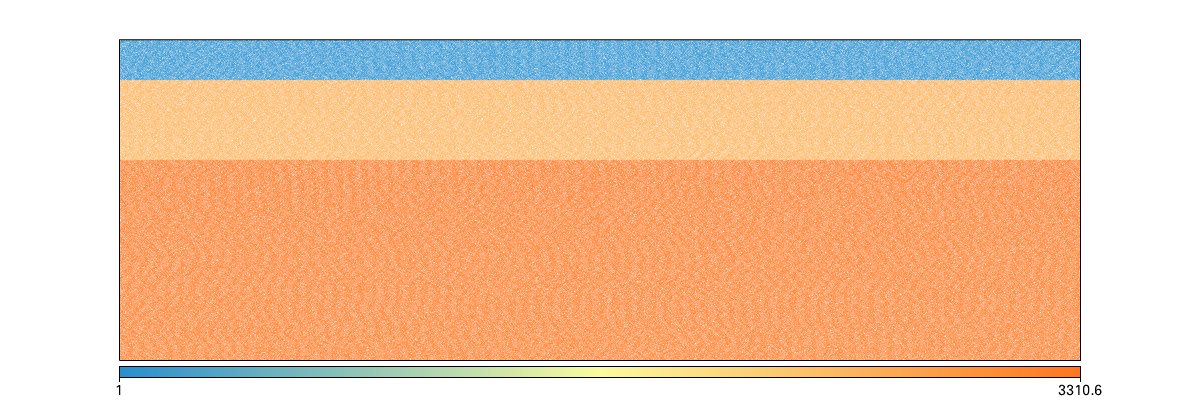

In [55]:
FigDensity = vis.Figure(figsize=(1200,400))
FigDensity.Points(Model.swarm, GEO.dimensionalise(Model.densityField, u.kilogram / u.meter ** 3))
FigDensity.show()


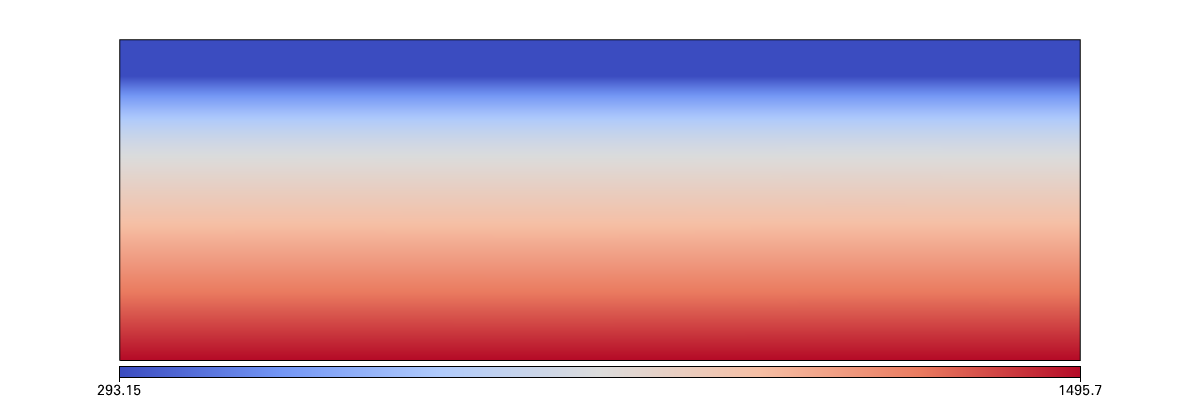

In [56]:
FigTemp = vis.Figure(figsize=(1200,400))
FigTemp.Surface(Model.mesh, GEO.dimensionalise(Model.temperature, u.degK), colours="coolwarm")
FigTemp.show()


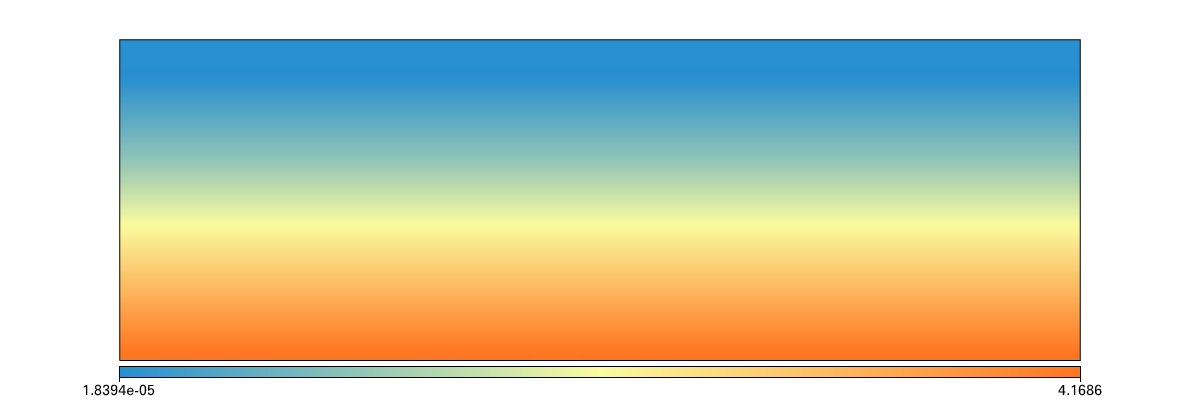

In [57]:
FigPress = vis.Figure(figsize=(1200,400))
FigPress.Surface(Model.mesh, GEO.dimensionalise(Model.pressureField, u.gigapascal))
FigPress.show()


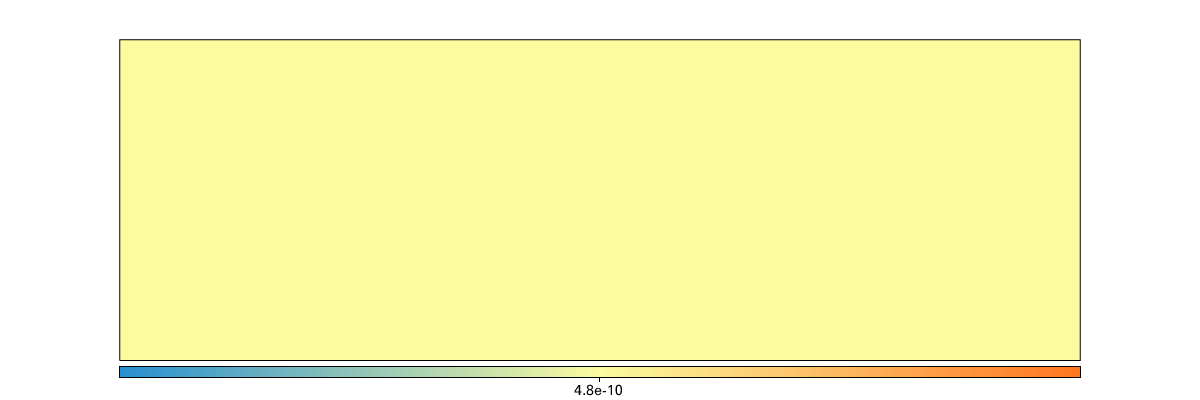

In [58]:
FigPress = vis.Figure(figsize=(1200,400))
FigPress.Surface(Model.mesh, GEO.dimensionalise(Model.strainRateField, u.metre / u.second))
FigPress.show()

# Extract information

### Temperature at the Moho

<font color='red'>WARNING: The next cell is NOT PARALLEL SAFE and will results in an error if you try to run it on multiple CPUs. You MUST delete it before attempting to run the model in parallel. </font>

In [59]:
if GEO.uw.mpi == 1:

   moho_average_temperature = Model.temperature.evaluate(Model.Moho_tracers).mean()
   moho_average_temperature = GEO.dimensionalise(moho_average_temperature, u.degC)

   print("Average Temperature at Moho: {0:5.0f}".format(moho_average_temperature))

In [60]:
moho_average_temperature = Model.temperature.evaluate(Model.Moho_tracers).mean()

In [61]:
moho_average_temperature

0.67837115247332347

In [62]:
moho_average_temperature = GEO.dimensionalise(moho_average_temperature, u.degC)

In [63]:
moho_average_temperature

629.08363278952027 <Unit('degC')>

In [64]:
print("Average Temperature at Moho: {0:5.0f}".format(moho_average_temperature))

Average Temperature at Moho: 629 degC


<font color='red'>WARNING: The next cell is NOT PARALLEL SAFE and will results in an error if you try to run it on multiple CPUs. You MUST delete it before attempting to run the model in parallel. </font>

/home/julian/codes/venv/py39/lib/python3.9/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/home/julian/codes/venv/py39/lib/python3.9/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


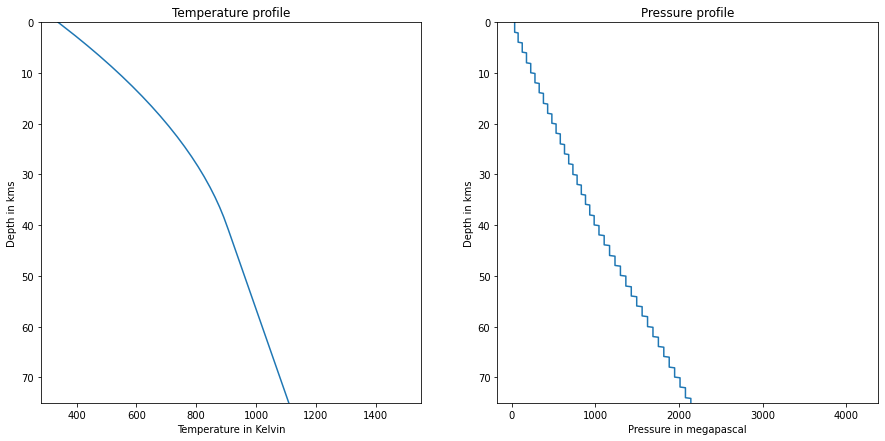

In [65]:
if GEO.uw.mpi.size == 1:
    import matplotlib.pyplot as plt

    distances, temperature = GEO.extract_profile(Model.temperature, line = [(180.* u.kilometer, 0.), (180.* u.kilometer, Model.bottom)])
    distances, pressure = GEO.extract_profile(Model.pressureField, line = [(180.* u.kilometer, 0.), (180.* u.kilometer, Model.bottom)])

    Fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7))
    ax1.plot(GEO.dimensionalise(temperature, u.degK), GEO.dimensionalise(distances, u.kilometer))
    ax1.set_xlabel("Temperature in Kelvin")
    ax1.set_ylabel("Depth in kms")
    ax1.set_ylim(75, 0)
    ax1.set_title("Temperature profile")

    ax2.plot(GEO.dimensionalise(pressure, u.megapascal), GEO.dimensionalise(distances, u.kilometer))
    ax2.set_xlabel("Pressure in megapascal")
    ax2.set_ylabel("Depth in kms")
    ax2.set_title("Pressure profile")
    ax2.set_ylim(75, 0)
    plt.show()

## Visualise Solidus and Liquidus

<font color='red'>WARNING: The next cell is NOT PARALLEL SAFE and will results in an error if you try to run it on multiple CPUs. You MUST delete it before attempting to run the model in parallel. </font>

/home/julian/codes/venv/py39/lib/python3.9/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/home/julian/codes/venv/py39/lib/python3.9/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/home/julian/codes/venv/py39/lib/python3.9/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/home/julian/codes/venv/py39/lib/python3.9/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/home/julian/codes/venv/py39/lib/python3.9/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is str

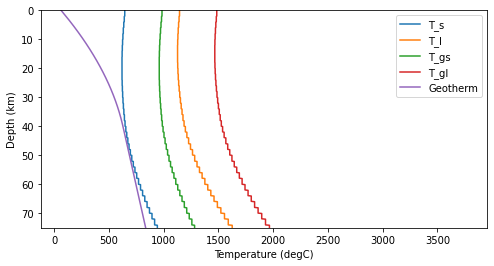

In [66]:
if GEO.uw.mpi.size == 1:
    T_s = my_crust_solidus.temperature(pressure)
    T_l = my_crust_liquidus.temperature(pressure)
    T_gs = mid_crust_solidus.temperature(pressure)
    T_gl = mid_crust_liquidus.temperature(pressure)
    depths = distances

    import pylab as plt

    fig = plt.figure(figsize=(8,4))
    plt.plot(GEO.dimensionalise(T_s, u.degC),GEO.dimensionalise(depths, u.kilometer), label="T_s")
    plt.plot(GEO.dimensionalise(T_l, u.degC),GEO.dimensionalise(depths, u.kilometer), label="T_l")
    plt.plot(GEO.dimensionalise(T_gs, u.degC),GEO.dimensionalise(depths, u.kilometer), label="T_gs")
    plt.plot(GEO.dimensionalise(T_gl, u.degC),GEO.dimensionalise(depths, u.kilometer), label="T_gl")
    plt.plot(GEO.dimensionalise(temperature, u.degC),GEO.dimensionalise(depths, u.kilometer), label="Geotherm")
    plt.xlabel("Temperature (degC)")
    plt.ylabel("Depth (km)")
    plt.legend()
    plt.ylim(75, 0)
    plt.show()


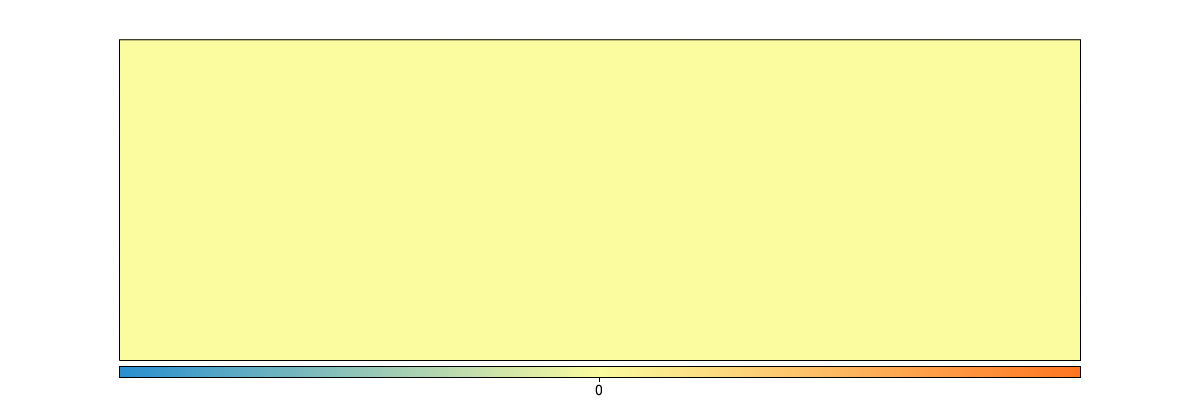

In [67]:
Model.update_melt_fraction()
FigMelt = vis.Figure(figsize=(1200,400))
FigMelt.Points(Model.swarm, Model.meltField, fn_size=3.0)
FigMelt.show()

/home/julian/codes/venv/py39/lib/python3.9/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


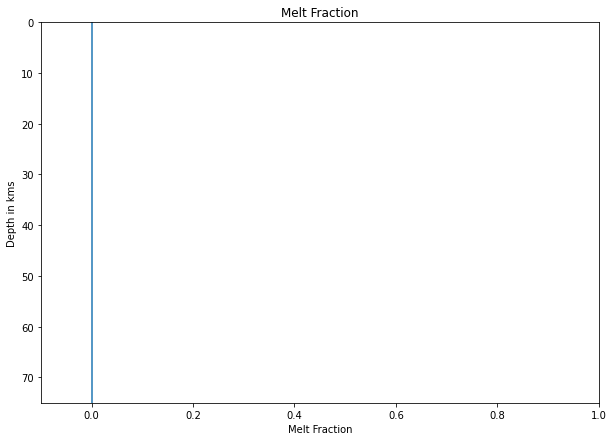

In [68]:
if GEO.uw.mpi.size == 1:
    distances, meltFraction = GEO.extract_profile(Model.projMeltField, 
                                                  line = [(180.* u.kilometer, 0.),
                                                          (180.* u.kilometer, Model.bottom)])

    Fig, ax1 = plt.subplots(1,1,figsize=(10,7))
    ax1.plot(meltFraction, GEO.dimensionalise(distances, u.kilometer))
    ax1.set_xlabel("Melt Fraction")
    ax1.set_ylabel("Depth in kms")
    ax1.set_ylim(75, 0)
    ax1.set_xlim(-0.1, 1.0)
    ax1.set_title("Melt Fraction")


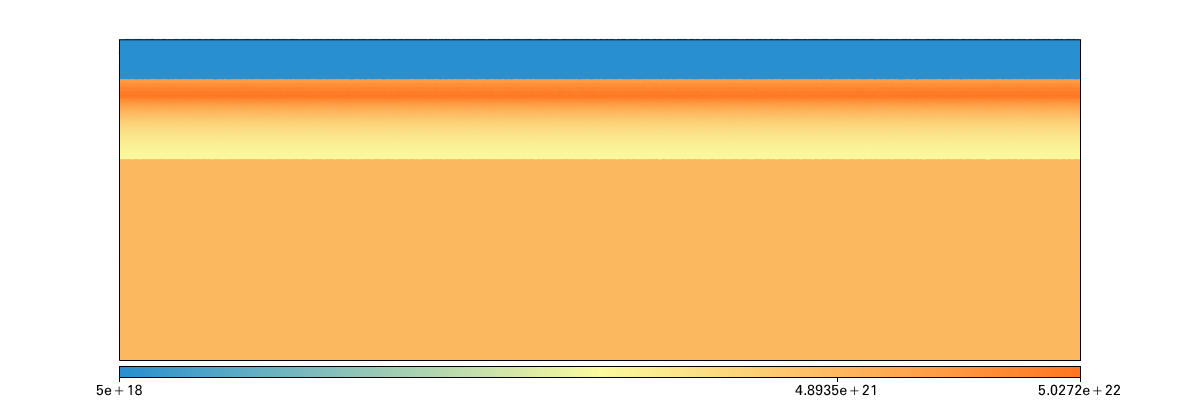

In [69]:
FigVisc = vis.Figure(figsize=(1200,400))
FigVisc.Points(Model.swarm, GEO.dimensionalise(Model.viscosityField, u.pascal*u.second), fn_size=3.0, logScale=True)
FigVisc.show()

/home/julian/codes/venv/py39/lib/python3.9/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


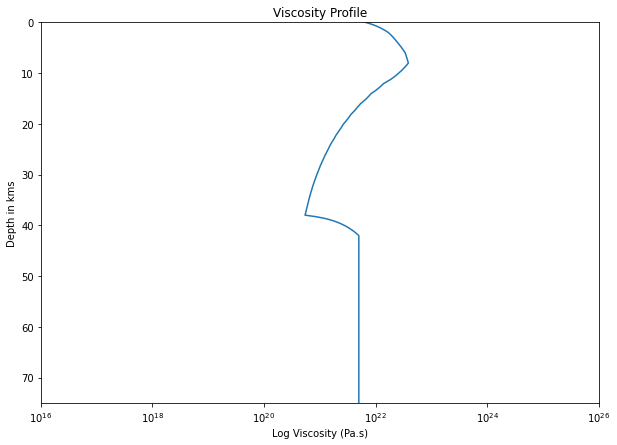

In [70]:
if GEO.uw.mpi.size == 1:
    distances, viscosities = GEO.extract_profile(Model.projViscosityField, 
                                                 line = [(180.* u.kilometer, 0.),
                                                         (180.* u.kilometer, Model.bottom)])

    Fig, ax1 = plt.subplots(1,1,figsize=(10,7))
    ax1.plot(GEO.dimensionalise(viscosities, u.pascal*u.second), GEO.dimensionalise(distances, u.kilometer))
    ax1.set_xscale("log")
    ax1.set_xlabel("Log Viscosity (Pa.s)")
    ax1.set_ylabel("Depth in kms")
    ax1.set_ylim(75, 0)
    ax1.set_xlim(1e16, 1e26)
    ax1.set_title("Viscosity Profile")

In [71]:
solver = Model.solver

In [72]:
if resolution[0] * resolution[1] < 1e6:
    print("Using mumps")
    solver.set_inner_method("mumps")
else:
    print("Using multigrid with coarse mumps")
    solver.options.A11.mg_coarse_pc_factor_mat_solver_package = "mumps"
    solver.options.A11.mg_coarse_pc_type = "lu"
    solver.options.A11.mg_coarse_ksp_type = "preonly"

Using mumps


In [73]:
Model.solver.set_penalty(1e6)

In [74]:
## ACTIVATE THIS CELL FOR PHASE 2 (DELAMINATION) OF THE MODEL
## UPDATE ACCORDING TO RESTART STEP, TIME (70 my in case of slow shortening, 7 my in case of fast shortening)
#def post_solve_hook():
#    new_heat_BC_flow =  (- 0.000000004 * u.watt / u.metre**2/u.year)*(Model.time - 70 * u.megayear ) - 0.020 * u.watt / u.meter**2
#    Model.set_heatFlowBCs(bottom=(new_heat_BC_flow, uppermantle))
#    print("New heat flow is {}".format(new_heat_BC_flow))
        
#Model.postSolveHook = post_solve_hook

In [75]:
## ACTIVATE THIS CELL FOR PHASE 3 (COLLAPSE) OF THE MODEL
## UPDATE ACCORDING TO RESTART STEP, TIME (72.5 my in case of slow shortening, 9.5 my in case of fast shortening) and BHF VALUES if necessary
#def post_solve_hook():  
#    new_heat_BC_flow =  (0.0000000002 * u.watt / u.metre**2/u.year)*(Model.time - 72.5 * u.megayear ) - 0.030 * u.watt / u.meter**2
#    Model.set_heatFlowBCs(bottom=(new_heat_BC_flow, uppermantle))
#    print("New heat flow is {}".format(new_heat_BC_flow))
    
#Model.postSolveHook = post_solve_hook

In [76]:
def post_hook():  
##    Stop any brittle yielding near the edges of the model
    coords = fn.input()
    zz = (coords[0] - GEO.nd(Model.minCoord[0])) / (GEO.nd(Model.maxCoord[0]) - GEO.nd(Model.minCoord[0]))
    fact = fn.math.pow(fn.math.tanh(zz*20.0) + fn.math.tanh((1.0-zz)*20.0) - fn.math.tanh(20.0), 4)
    Model.plasticStrain.data[:] = Model.plasticStrain.data[:] * fact.evaluate(Model.swarm)

In [79]:
## ACTIVATE THIS CELL FOR PHASE 1 (SHORTENING) OF THE MODEL
# Model.run_for(7000000.* u.years, checkpoint_interval=50000. * u.year)

In [80]:
## ACTIVATE THIS CELL FOR PHASE 2 (DELAMINATION) and 3 (COLLAPSE) OF THE MODEL
## ADJUST RESTART RUN TIME AND STEP
#Model.run_for(12000000.* u.years, restartStep=2620, restartDir= "outputs_script-G48875-Cenki-etal_Phaneroz2bis", checkpoint_interval=50000. * u.year)